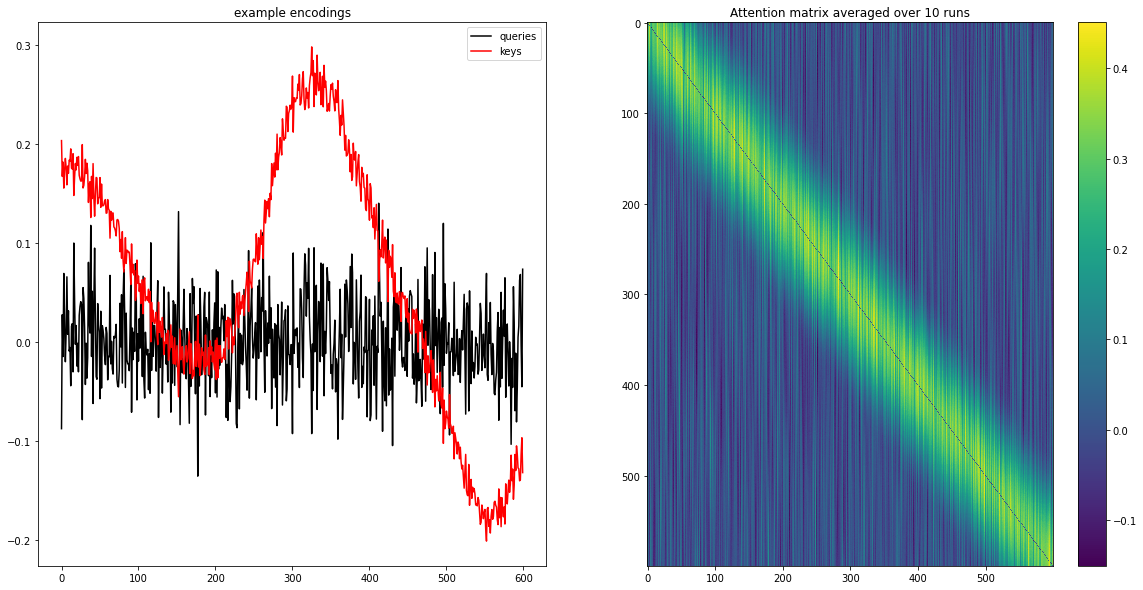

In [1]:
%load_ext autoreload
%autoreload 2

import torch
import spe
import numpy as np
import matplotlib.pyplot as plt
from torch.fft import rfft, irfft
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# dimension for the keys and queries
key_dim = 32

# create the positional encoder, with a specified max lag
spectral = False
if spectral:
    encoder = spe.SpectralSPE(dimension=key_dim, max_lag=200, init_lengthscale=100).to(device)
else:
    encoder = spe.ConvSPE(rank=1, dimension=key_dim, kernel_size=250).to(device)

# draw keys and queries, as one for the test (activate all patterns)
n = 600
q = torch.ones(1, key_dim, n, device=device)
k = torch.ones(1, key_dim, n, device=device)


# compute the average attention matrix
n_average_A = 10
A=0
for it in range(n_average_A):
    # generate some encodings of shape (batchsize, num, n)
    qhat, khat = encoder(q,k,num=512)
    A = A + torch.mm(qhat[0].detach().T, khat[0].detach())
A = A / n_average_A

# display some queries and keys
qhat = qhat.detach()
khat = khat.detach()

plt.figure(figsize=[20,10]);
plt.subplot(121)
plt.plot(khat[0,:1,:].cpu().T,'k');
plt.plot(qhat[0,:1,:].cpu().T,'r');
plt.title('example encodings');
plt.legend(['queries', 'keys']);

# display the average dot product
plt.subplot(122);
plt.imshow(A.detach().cpu().numpy(), aspect='auto', interpolation='nearest');
plt.title('Attention matrix averaged over {} runs'.format(n_average_A));
plt.colorbar();

In [4]:
qhat.shape

torch.Size([1, 32, 600])

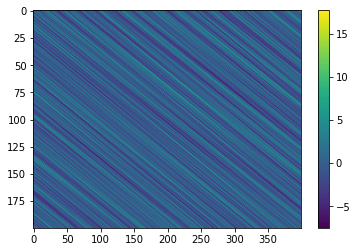

In [75]:
# IDEA: 
#generate random toeplitz matrices with a V_q D V_k^H decomposition
m = 200
n= 400
r=50

# generate random frequencies (on the unit circle) exp(i 2 pi f ) with f in [0 1]
v = torch.randn(r, dtype=torch.cfloat); v=v/v.abs()

# rotate them according to some positions
Vq = v[None, :] ** torch.linspace(0,1000,m)[:, None]
Vk = v[None, :] ** torch.linspace(1000,2000,n)[:, None]

# draw random weights for each frequency
lamb = torch.rand(r)

# compute the encodings
Q = Vq*lamb[None]
K = Vk*lamb[None]

plt.imshow(torch.mm(Q, torch.conj(K.T)).real.detach().cpu().numpy(), aspect='auto')
plt.colorbar()